In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomDecoder4(nn.Module):
    def __init__(self, encoder):
        super(CustomDecoder4, self).__init__()

        self.encoder = encoder

        for param in self.encoder.parameters():
            param.requires_grad = False

        # Upsample to [batch_size, 128, 60, 80]
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU(inplace=True)

        # Upsample to [batch_size, 64, 120, 160]
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)

        # Upsample to [batch_size, 64, 240, 320]
        self.up3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)

        # Upsample to [batch_size, 32, 480, 640]
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU(inplace=True)

        # Final convolution to get 21 channels for the segmentation map
        self.final_conv = nn.Conv2d(32, 21, kernel_size=1)

    def forward(self, x):
        with torch.no_grad():
            x, diff, (_, _, ind) = self.encoder.encode(x)

        x = self.up1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.up2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.up3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.up4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.final_conv(x)
        return x

In [4]:
!ls

sample_data  segm_model_nyu_30-epochs.pth


In [5]:
segm_model = torch.load('segm_model_nyu_30-epochs.pth')

# If you're loading the model for inference, don't forget to call eval()
segm_model.eval()

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import torch

In [ ]:
# nyu dataset - 2 part validate, train
# frame -> rgb, labels


In [ ]:
'''import os
# delete all files that do not end with _colors.png
# Specify the folder name
folder_name = "drive/MyDrive/frames"

# List all files in the directory
files_in_directory = os.listdir(folder_name)

# Loop through all files
for filename in files_in_directory:
    # Construct the full file path
    file_path = os.path.join(folder_name, filename)
    # Check if the file does not end with '_colors.png'
    if not filename.endswith('_colors.png'):
        # If it doesn't, delete the file
        os.remove(file_path)
        print(f'Deleted {file_path}')  # Optional: print confirmation
'''

In [ ]:
import os
# count how many file are in dir
# Specify the folder name
folder_name =  "drive/MyDrive/frames_segm" # Replace with the path to your folder frames_rgb

# List all files in the directory
files_in_directory = os.listdir(folder_name)

# Initialize counters
total_files = 0
colors_png_files = 0
mask_files = 0
other_files = 0

# Loop through all files
for filename in files_in_directory:
    # Increment total files counter
    total_files += 1
    # Check if the file ends with '_colors.png'
    if filename.endswith('_colors.png'):
        colors_png_files += 1
    elif filename.endswith('_mask.png'):
      mask_files += 1
    else:
        other_files += 1

# Print the counts
print(f"Total number of files: {total_files}")
print(f"Number of '_colors.png' files: {colors_png_files}")
print(f"Number of '_mask.png' files: {mask_files}")
print(f"Number of other files: {other_files}")

Total number of files: 0
Number of '_colors.png' files: 0
Number of '_mask.png' files: 0
Number of other files: 0


In [ ]:
# 281 examples

In [ ]:
import os
import shutil

def move_files_to_directory(source_dir, destination_dir):
    # Ensure the destination directory exists, create if it does not
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Walk through all subdirectories in the source directory
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Construct the full file path
            file_path = os.path.join(root, file)
            # Construct the destination file path
            destination_file_path = os.path.join(destination_dir, file)

            # Move the file
            shutil.move(file_path, destination_file_path)
            print(f"Moved: {file_path} -> {destination_file_path}")

# Example usage
source_directory = "drive/MyDrive/nyu2_train"
destination_directory = "drive/MyDrive/nyu2_part2"
move_files_to_directory(source_directory, destination_directory)

In [ ]:
import torchvision.models.segmentation as segmentation

pre_trained_segm_model = segmentation.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 56.3MB/s]


In [ ]:
import torchvision.transforms as T

deep_lab_transform = T.Compose([
    T.Resize((520, 520)),  # Resize the image to the input size expected by the model
    T.ToTensor(),  # Convert the image to a tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])


def load_and_transform_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB
    return deep_lab_transform(image).unsqueeze(0)  # Add a batch dimension

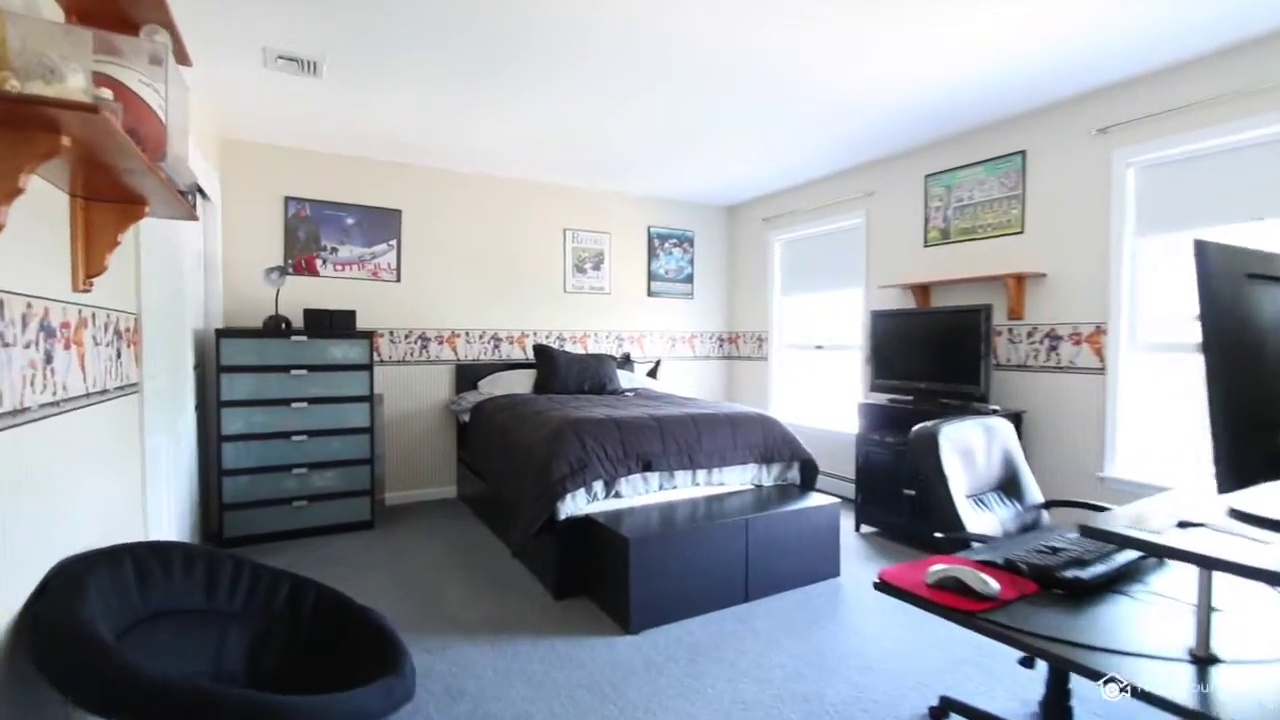

In [ ]:
from PIL import Image
from IPython.display import display

# Specify the path to your image
image_path = 'drive/MyDrive/frames/frame160.jpg'

# Open the image
image = Image.open(image_path)

# Display the image inline
display(image)

In [ ]:
input_image = load_and_transform_image(image_path)
pre_trained_segm_model.eval()

with torch.no_grad():
  seg_output = pre_trained_segm_model(input_image)['out'][0]
seg_output.shape

torch.Size([21, 520, 520])

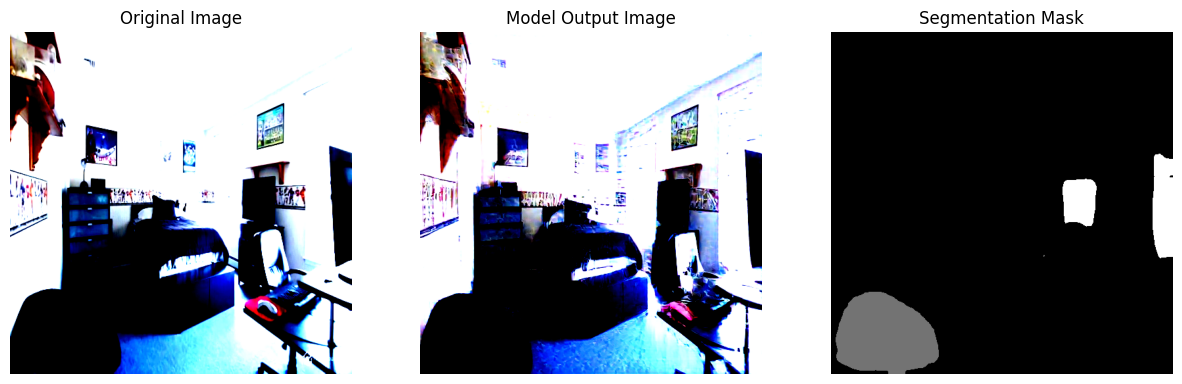

In [ ]:
# Plot
original_img = input_image[0]
original_img = original_img.permute(1, 2, 0).numpy() #
provided_img = output[0][0]
provided_img = provided_img.permute(1, 2, 0).numpy()
segmentation_mask = seg_output.argmax(0).numpy()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Original Image
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Provided Image (Model Output)
axs[1].imshow(provided_img)
axs[1].set_title('Model Output Image')
axs[1].axis('off')

# Segmentation Mask
# Assuming the mask is grayscale; if it has labels, you might want to apply a colormap
axs[2].imshow(segmentation_mask, cmap='gray')  # Use 'cmap' to specify a colormap for labels if needed
axs[2].set_title('Segmentation Mask')
axs[2].axis('off')

plt.show()

# Move and transform data in folders

In [ ]:
input_folder = "drive/MyDrive/frames_test_rgb"
output_folder = "drive/MyDrive/frames_test_segm"

pre_trained_segm_model.eval()

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if ".png" in filename:
        image_path = os.path.join(input_folder, filename)
        input_image = load_and_transform_image(image_path)

        with torch.no_grad():  # No need to compute gradients
            output = pre_trained_segm_model(input_image)['out'][0]
        output_predictions = output.argmax(0)

        # Convert the tensor to a PIL image and save it
        mask = T.ToPILImage()(output_predictions.byte())
        mask.save(os.path.join(output_folder, filename.replace("_colors.png", "_mask.png")))
        print(f'create img mask {filename.replace("_colors.png", "_mask.png")}')

create img mask frame134_mask.png
create img mask frame133_mask.png
create img mask frame132_mask.png
create img mask frame13_mask.png
create img mask frame131_mask.png
create img mask frame130_mask.png
create img mask frame128_mask.png
create img mask frame127_mask.png
create img mask frame126_mask.png
create img mask frame129_mask.png
create img mask frame116_mask.png
create img mask frame112_mask.png
create img mask frame108_mask.png
create img mask frame114_mask.png
create img mask frame109_mask.png
create img mask frame110_mask.png
create img mask frame115_mask.png
create img mask frame111_mask.png
create img mask frame107_mask.png
create img mask frame125_mask.png
create img mask frame124_mask.png
create img mask frame123_mask.png
create img mask frame121_mask.png
create img mask frame12_mask.png
create img mask frame120_mask.png
create img mask frame118_mask.png
create img mask frame117_mask.png
create img mask frame119_mask.png
create img mask frame122_mask.png
create img mask 

In [ ]:
# convert to png and save files as some_id_colors.png
import os
from PIL import Image
import glob

input_folder = "drive/MyDrive/frames_test"
output_folder = 'drive/MyDrive/frames_test_rgb'


if not os.path.exists(output_folder):
    os.makedirs(output_folder)

count = 0

# Use glob to find all jpg files in the directory
for jpg_file in glob.glob(os.path.join(input_folder, '*.jpg')):
    # Open the image file
    with Image.open(jpg_file) as img:
        # Define the new filename, replace '.jpg' with '_colors.png'
        png_file = jpg_file.rsplit('.', 1)[0] + '_colors.png'
        png_file = png_file.replace('frames_test', 'frames_test_rgb')

        # Save the file in PNG format
        img.save(png_file, 'PNG')
        count += 1
        # img.save(png_file, 'PNG')

        # print(f'Converted {jpg_file} to {png_file}')
print(f'Created {count} files')
# Optional: Remove the original JPG files after conversion
# Be careful with this step, uncomment the next lines if you're sure you want to delete the original files.
# for jpg_file in glob.glob(os.path.join(directory, '*.jpg')):
#     os.remove(jpg_file)
#     print(f'Removed {jpg_file}')

Created 100 files


In [ ]:
# Save the entire model
model_save_path = 'pre_trained_segm_model.pth'
torch.save(pre_trained_segm_model, model_save_path)

In [ ]:
# Load the entire model
model = torch.load('pre_trained_segm_model.pth')

# If you're planning to use the model for inference only
model.eval()

# Loading original model

In [ ]:
%%capture
! pip install git+https://github.com/CompVis/geometry-free-view-synthesis#egg=geometry-free-view-synthesis
! pip install pytorch-lightning==1.7.7
! pip install torchmetrics==0.11.4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from geofree.util import get_local_path, OmegaConf
from geofree.main import instantiate_from_config
import torchvision.transforms as transforms
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
import copy

model="re_impl_nodepth"
prefix = model[:2]
assert prefix in ["re", "ac"], "not implemented"

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
config_path = get_local_path(model+"_config")
config = OmegaConf.load(config_path)
config.model.params.first_stage_config.params["ckpt_path"] = get_local_path(f"{prefix}_first_stage")
config.model.params.depth_stage_config.params["ckpt_path"] = get_local_path(f"{prefix}_depth_stage")

vqgan_config = config.model.params.first_stage_config
print(config)

3.07kB [00:00, 26.3kB/s]                            


304MB [00:31, 9.66MB/s]                           


289MB [00:29, 9.92MB/s]                           


{'model': {'base_learning_rate': 0.0625, 'target': 'geofree.models.transformers.geogpt.GeoTransformer', 'params': {'use_depth': False, 'plot_cond_stage': True, 'monitor': 'val/loss', 'use_scheduler': True, 'scheduler_config': {'target': 'geofree.lr_scheduler.LambdaWarmUpCosineScheduler', 'params': {'verbosity_interval': 0, 'warm_up_steps': 5000, 'max_decay_steps': 500001, 'lr_start': 2.5e-06, 'lr_max': 0.00015, 'lr_min': 1e-08}}, 'transformer_config': {'target': 'geofree.modules.transformer.mingpt.GPT', 'params': {'vocab_size': 16384, 'block_size': 627, 'n_unmasked': 329, 'n_layer': 32, 'n_head': 16, 'n_embd': 1024}}, 'first_stage_key': {'x': 'dst_img'}, 'cond_stage_key': {'c': 'src_img'}, 'emb_stage_key': {'points': 'src_points', 'R': 'R_rel', 't': 't_rel', 'K': 'K', 'K_inv': 'K_inv'}, 'first_stage_config': {'target': 'geofree.models.vqgan.VQModel', 'params': {'ckpt_path': '/root/.cache/geofree/re_first_stage/last.ckpt', 'embed_dim': 256, 'n_embed': 16384, 'ddconfig': {'double_z': Fal

In [ ]:
model = instantiate_from_config(vqgan_config)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /root/.cache/geofree/re_first_stage/last.ckpt


In [ ]:
# Save the entire model
##model_save_path = 'original_model.pth'
#torch.save(model, model_save_path)

In [ ]:
import torchvision.transforms as T

deep_lab_transform = T.Compose([
    T.Resize((520, 520)),  # Resize the image to the input size expected by the model
    T.ToTensor(),  # Convert the image to a tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])


def load_and_transform_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB
    return deep_lab_transform(image).unsqueeze(0)  # Add a batch dimension

In [ ]:
# try feeding example

image_path = 'frame0.jpg'

input_image = Image.open(image_path).convert("RGB")

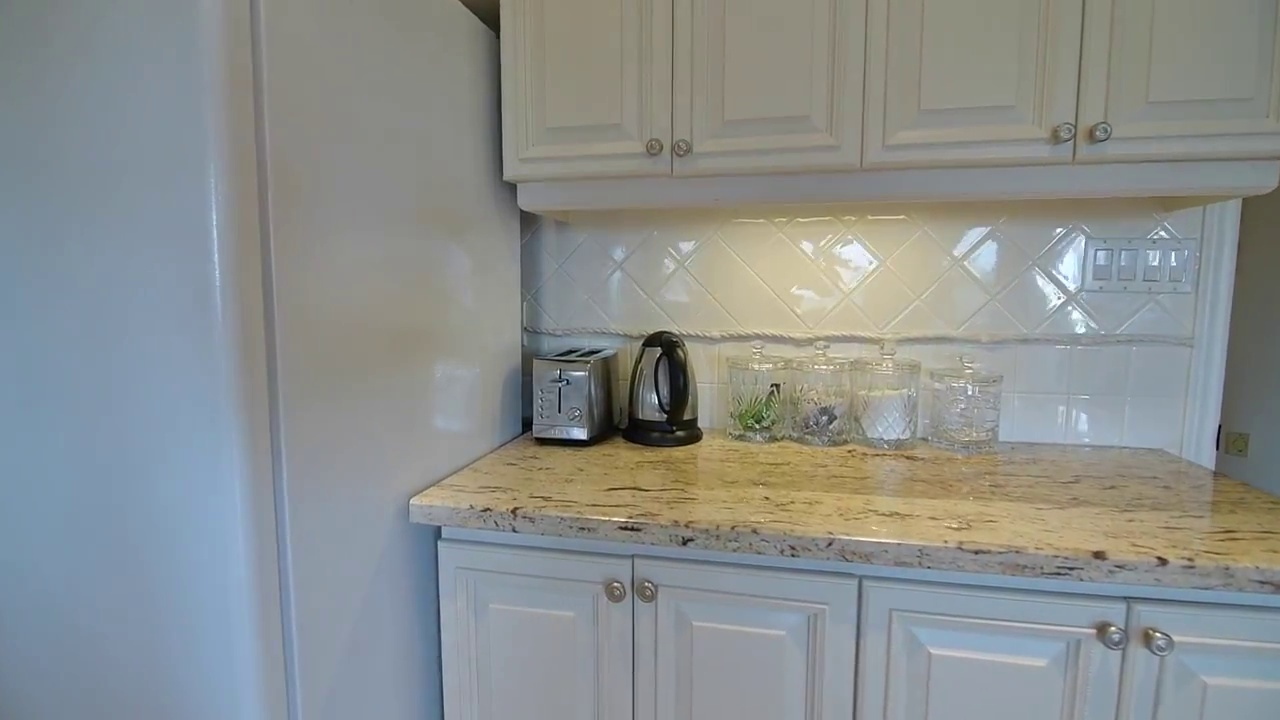

In [ ]:
input_image

In [ ]:
import torchvision.transforms as T
transf = T.ToTensor()
input_batch = transf(input_image).unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 720, 1280])

In [ ]:
model.eval()

with torch.no_grad():
  output = model(input_batch)

In [ ]:
def print_img_from_tensor_batch(batch):
  img = batch[0][0]
  img = img.permute(1, 2, 0).numpy()
  img = np.clip(img, 0, 1)
  # plot the image
  plt.imshow(img)
  plt.axis('off')  # Turn off axis numbers and ticks
  plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def print_img_from_tensor_batch(batch, dpi=100):
    # Assuming batch is a torch.Tensor of shape (N, C, H, W)
    img = batch[0][0]  # Get the first image in the batch
    img = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

    # Optionally, denormalize your image here if it was normalized

    height, width, _ = img.shape

    # Calculate the figure size in inches (Width, Height)
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure with the calculated size
    plt.figure(figsize=figsize, dpi=dpi)

    plt.imshow(img)
    plt.axis('off')  # Hide axis ticks and labels
    plt.show()

# Example usage
# print_img_from_tensor_batch(your_batch_tensor, dpi=100)


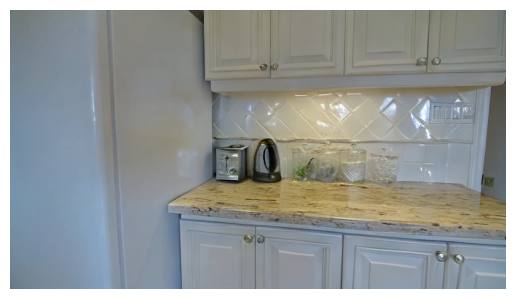

In [ ]:
print_img_from_tensor_batch(output)

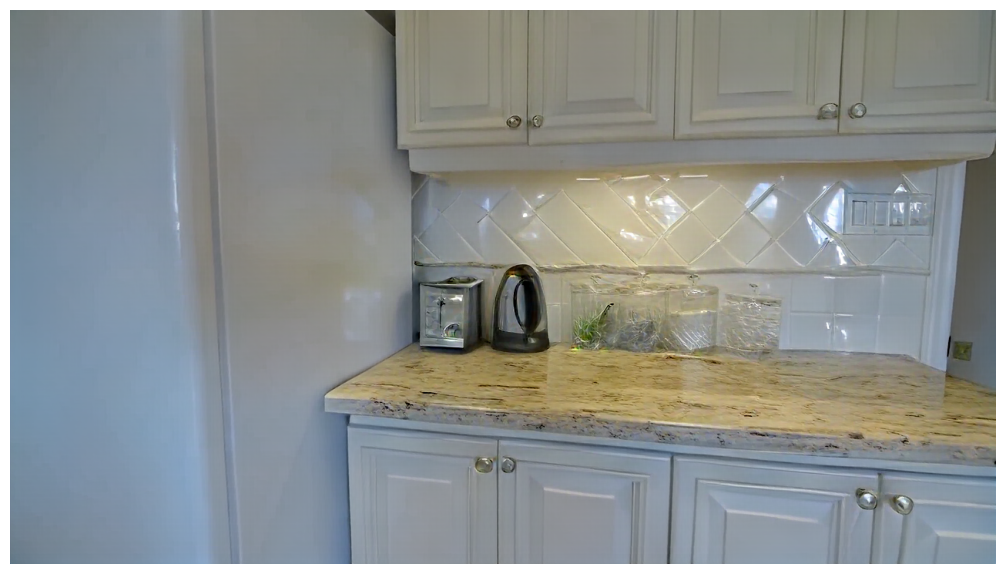

In [ ]:
print_img_from_tensor_batch(output)

In [ ]:
from PIL import Image
from IPython.display import display

# Specify the path to your image
image_path = '/frame0.jpg'

# Open the image
image = Image.open(image_path)

# Display the image inline
display(image)

In [ ]:
original_img = input_image[0]
original_img = original_img.permute(1, 2, 0).numpy() #
provided_img = output[0][0]
provided_img = provided_img.permute(1, 2, 0).numpy()
segmentation_mask = seg_output.argmax(0).numpy()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Original Image
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Provided Image (Model Output)
axs[1].imshow(provided_img)
axs[1].set_title('Model Output Image')
axs[1].axis('off')

# Segmentation Mask
# Assuming the mask is grayscale; if it has labels, you might want to apply a colormap
axs[2].imshow(segmentation_mask, cmap='gray')  # Use 'cmap' to specify a colormap for labels if needed
axs[2].set_title('Segmentation Mask')
axs[2].axis('off')

plt.show()

In [ ]:
input_image = load_and_transform_image(image_path)
pre_trained_segm_model.eval()

with torch.no_grad():
  seg_output = pre_trained_segm_model(input_image)['out'][0]
seg_output.shape

torch.Size([21, 520, 520])

In [ ]:
output[0][0].shape

torch.Size([3, 512, 512])

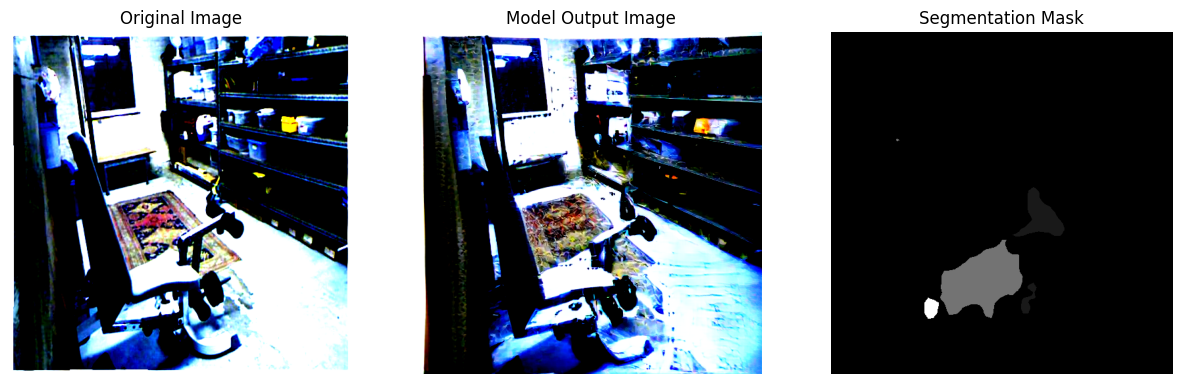

In [ ]:
# Plot
original_img = input_image[0]
original_img = original_img.permute(1, 2, 0).numpy() #
provided_img = output[0][0]
provided_img = provided_img.permute(1, 2, 0).numpy()
segmentation_mask = seg_output.argmax(0).numpy()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Original Image
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Provided Image (Model Output)
axs[1].imshow(provided_img)
axs[1].set_title('Model Output Image')
axs[1].axis('off')

# Segmentation Mask
# Assuming the mask is grayscale; if it has labels, you might want to apply a colormap
axs[2].imshow(segmentation_mask, cmap='gray')  # Use 'cmap' to specify a colormap for labels if needed
axs[2].set_title('Segmentation Mask')
axs[2].axis('off')

plt.show()

# evaluation

In [ ]:
import torch

# Function to calculate IoU
def iou_score(output, target, n_classes):
    # Initialize the confusion matrix
    confusion_matrix = torch.zeros((n_classes, n_classes), device=output.device)

    # Predicted classes and target classes
    _, preds = torch.max(output, 1)

    for pred, t in zip(preds.view(-1), target.view(-1)):
        confusion_matrix[t.long(), pred.long()] += 1

    # Diagonal elements represent correct predictions
    true_positive = torch.diag(confusion_matrix)
    # Sum of each row (actual classes)
    total_target = confusion_matrix.sum(1)
    # Sum of each column (predicted classes)
    total_pred = confusion_matrix.sum(0)

    # IoU for each class
    iou_per_class = true_positive / (total_target + total_pred - true_positive)

    # Handling NaNs
    iou_per_class[torch.isnan(iou_per_class)] = 0

    # Mean IoU
    mean_iou = torch.mean(iou_per_class)

    return mean_iou

# Assuming you have a defined DataLoader for your training data
total_iou = 0.0
count = 0

for img, mask in train_loader:
    img = img.to(device)
    mask = mask.to(device)

    # Forward pass to get the output from the model
    outputs = segm_model(img)

    # Calculate IoU
    iou = iou_score(outputs, mask, n_classes=21) # Assuming 21 classes including the background
    total_iou += iou
    count += 1

# Calculate the average IoU over all batches
average_iou = total_iou / count
print(f'Average IoU over the training set: {average_iou.item()}')


In [ ]:
from PIL import Image
from IPython.display import display


In [ ]:
input_image = load_and_transform_image(image_path)
pre_trained_segm_model.eval()

with torch.no_grad():
  seg_output = pre_trained_segm_model(input_image)['out'][0]
seg_output.shape

In [ ]:
'''# Load data
from PIL import Image
from IPython.display import display

# Specify the path to your image
image_path = 'drive/MyDrive/nyu_data/data/nyu2_test/00000_colors.png'# 'city_img.jpeg'# 'frames/frame51.jpg'

# Open the image
image = Image.open(image_path)

# Display the image inline
display(image)'''